# Validating a multivariable regression
#### Emile Badran U2 L5 P2

This notebook uses the [2013](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) and [2014](https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls) FBI:UCR Crime datasets.

Based on the results of the previous validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include the model and a brief writeup of the reasoning behind the chosen validation method and the changes made.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Refactoring the model:

Instead of converting the data to crime rates per 1000 population, I'll include population data into the model and exclude outliers.

The first round will be tested with 2013 data:

In [2]:
# Reading the Excel sheet:
data = pd.read_excel('fbi_ny_2013.xls', sheet_name=0, header=1, skiprows=3, skip_footer=7,
                     index_col=0, thousands=None)

data.columns = ['population', 'violent_crime',
       'murder','rape', 'rape_legacy',
       'robbery', 'assault', 'property_crime', 'burglary',
       'larceny_theft', 'vehicle_theft', 'arson']
data.index.names = ['city']
data = data.fillna(0)
data = data.astype('int64')

In [3]:
df = data[['population','property_crime','rape_legacy','murder','assault','robbery']]
df.shape

(344, 6)

In [4]:
# Delete outliers:
df = df[df.population < df.population.quantile(.98)]
df.shape

(337, 6)

### Transforming all variables to a more normal distribution:

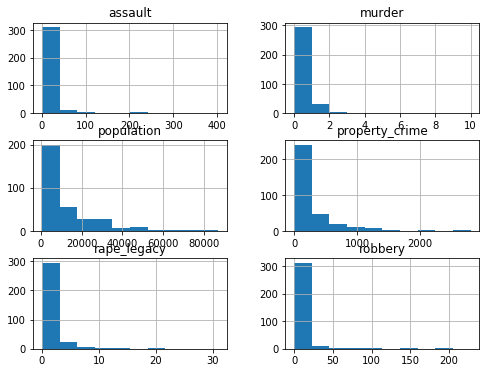

In [5]:
df.hist(figsize = (8,6))
plt.show()

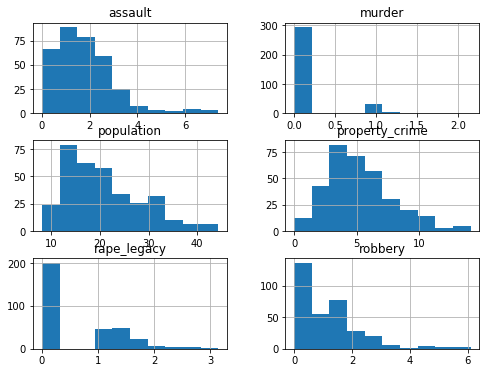

In [6]:
df = np.cbrt(df)
df.hist(figsize = (8,6))
plt.show()

#### Once again, murder doesn't have a very high correlation with property_crime and will be dropped.

In [7]:
df.corr()

,population,property_crime,rape_legacy,murder,assault,robbery
population,1.000000,0.870467,0.619839,0.490678,0.741192,0.773738
property_crime,0.870467,1.000000,0.732734,0.513714,0.837864,0.854390
rape_legacy,0.619839,0.732734,1.000000,0.494214,0.735244,0.701552
murder,0.490678,0.513714,0.494214,1.000000,0.594520,0.612419
assault,0.741192,0.837864,0.735244,0.594520,1.000000,0.840593
robbery,0.773738,0.854390,0.701552,0.612419,0.840593,1.000000


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.97409956  0.01863139  0.00386725]

Coefficients: 
 [ 0.29680204  0.74195355 -0.07273661]

Intercept: 
 5.28935416669

R-squared:
0.864333208278


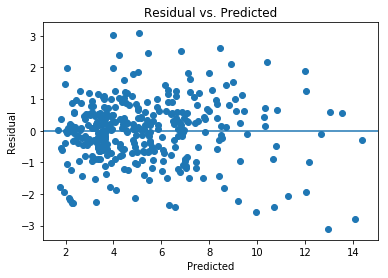

In [8]:
sklearn_pca = PCA(n_components=3)

Y_sklearn = sklearn_pca.fit_transform(df[['population','rape_legacy','assault','robbery']])
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# property_crime is the variable that we want to predict:
Y = df['property_crime']
# X is the dimensionally reduced component resulting from PCA:
X = Y_sklearn

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X, Y)

predicted = regr.predict(X).ravel()
actual = df['property_crime']

residual = actual - predicted

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Testing the predictions with holdout (60 / 40):

#### Running the regression with 60% training data:


Coefficients: 
 [ 0.28612475  0.67880229 -0.03089459]

Intercept: 
 5.26201113312

R-squared:
0.861036295417


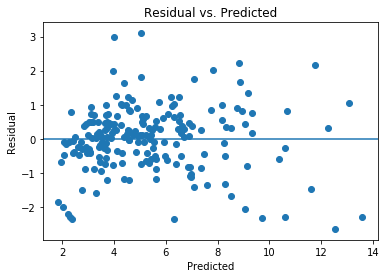

In [9]:
# property_crime is the variable that we want to predict:
Y = df['property_crime']
# X is the dimensionally reduced component resulting from PCA:
X = Y_sklearn

# Test the model with different holdout groups with sklearn:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=20)

regr.fit(X_train, y_train)

predicted = regr.predict(X_train).ravel()
actual = y_train

residual = actual - predicted

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_train, y_train))

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#### Running the regression with 40% testing data:


Coefficients: 
 [ 0.31086136  0.86043663 -0.17048182]

Intercept: 
 5.3369188664

R-squared:
0.874538595348


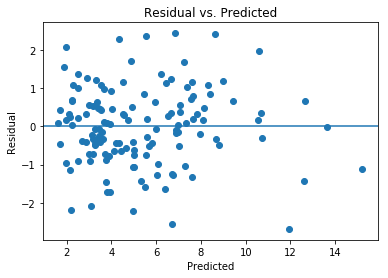

In [10]:
regr.fit(X_test, y_test)

predicted = regr.predict(X_test).ravel()
actual = y_test

residual = actual - predicted

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Cross-validation:

In [11]:
# X is the dimensionally reduced component resulting from PCA:
X = Y_sklearn

# property_crime is the variable that we want to predict:
Y = df['property_crime']

regr = regr.fit(X, Y)

cross_val_score(regr, X, Y, cv=10)

array([ 0.92023765,  0.90814429,  0.71380859,  0.85653819,  0.80836545,
        0.78302269,  0.82902447,  0.84074599,  0.84950435,  0.91065779])

## Running the model on the 2014 data set:

In [12]:
# Read the Excel sheet:
data = pd.read_excel('fbi_ny_2014.xls', sheet_name=0, header=1, skiprows=3, skip_footer=7,
                     index_col=0, thousands=None)

data.columns = ['population', 'violent_crime',
       'murder','rape', 'rape_legacy',
       'robbery', 'assault', 'property_crime', 'burglary',
       'larceny_theft', 'vehicle_theft', 'arson']
data.index.names = ['city']
data = data.fillna(0)
data = data.astype('int64')

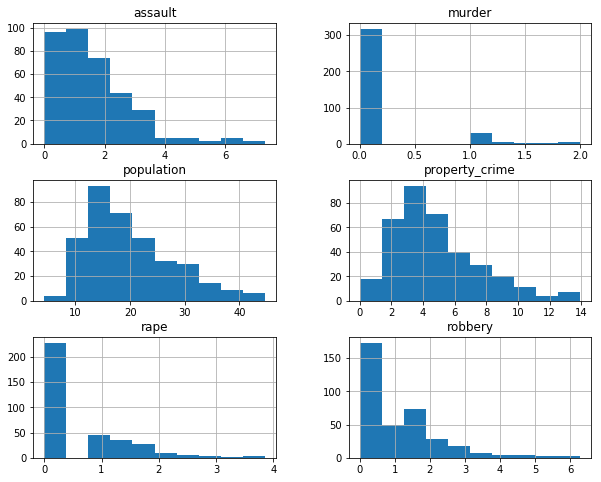

In [13]:
# Filter relevant variables:
df = data[['population','property_crime','rape','murder','assault','robbery']]

# Delete outliers:
df = df[df.population < df.population.quantile(.98)]

# Transform data to more normally distributed values:
df = np.cbrt(df)
df.hist(figsize = (10,8))
plt.show()

#### Murder doesn't have a very high correlation with property_crime and will be dropped.

In [14]:
df.corr()

,population,property_crime,rape,murder,assault,robbery
population,1.000000,0.860383,0.549684,0.523308,0.753023,0.796757
property_crime,0.860383,1.000000,0.668649,0.554343,0.827270,0.842275
rape,0.549684,0.668649,1.000000,0.355460,0.646682,0.595021
murder,0.523308,0.554343,0.355460,1.000000,0.601985,0.627743
assault,0.753023,0.827270,0.646682,0.601985,1.000000,0.825819
robbery,0.796757,0.842275,0.595021,0.627743,0.825819,1.000000


### Running the linear regression:

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.97335032  0.01731368  0.00534784]

Coefficients: 
 [ 0.2931032   0.75072532 -0.17214796]

Intercept: 
 4.77448421823

R-squared:
0.842874135949


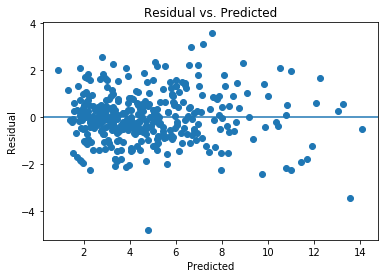

In [15]:
sklearn_pca = PCA(n_components=3)

Y_sklearn = sklearn_pca.fit_transform(df[['population','rape','assault','robbery']])
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# property_crime is the variable that we want to predict:
Y = df['property_crime']
# X is the dimensionally reduced component resulting from PCA:
X = Y_sklearn

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X, Y)

predicted = regr.predict(X).ravel()
actual = df['property_crime']

residual = actual - predicted

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Cross-validating:

In [16]:
# X is the dimensionally reduced component resulting from PCA:
X = Y_sklearn

# property_crime is the variable that we want to predict:
Y = df['property_crime']

regr = regr.fit(X, Y)

cross_val_score(regr, X, Y, cv=10)

array([ 0.90834043,  0.88777834,  0.67658433,  0.83989728,  0.83577874,
        0.73443669,  0.82614902,  0.75179507,  0.86478256,  0.84599408])

### Testing each parameter to see if it explains a statistically-significant amount of unique variance in the outcome:

In [17]:
# Write out the model formula:
linear_formula = 'property_crime ~ population+rape+assault+robbery'

# Fit the model to data using the formula:
lm = smf.ols(formula=linear_formula, data=df).fit()

print('MODEL COEFFICIENTS:\n',lm.params,'\n\nP-VALUES:\n',
      lm.pvalues,'\n\nR-SQUARED:\n',lm.rsquared)

MODEL COEFFICIENTS:
 Intercept     0.378282
population    0.148234
rape          0.518059
assault       0.414137
robbery       0.526961
dtype: float64 

P-VALUES:
 Intercept     4.854712e-02
population    5.385270e-28
rape          2.063888e-08
assault       5.165974e-07
robbery       6.579169e-08
dtype: float64 

R-SQUARED:
 0.845045639118
